In [1]:
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torchvision
from scipy import interpolate

device = 'cuda'
batch_size = 64
T = 1000
from functools import partial
from schedule import noising_sch

noising_sch = partial(noising_sch, T=T)

from beta import KL, sufficient_stats, alpha_beta, get_dist, sufficient_stats_part2


In [2]:
from tqdm import tqdm
from torch.distributions.beta import Beta
import torch
import time

from utils import sample_t_batch

sample_t_batch = partial(sample_t_batch, T=T)


def sample_chain(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    for s in range(T, int(t_min), -1):
        s_batch = torch.tensor([s], device=device).repeat(batch_size)
        helper_slice = helper[:, s]
        
        theta = noising_sch(t_batch)
        
        alpha, beta = alpha_beta(theta, x_0)
        
        dist = Beta(alpha, beta)
        samples.append(dist.sample())
        
        suff_stats += helper_slice.reshape([-1, 1, 1, 1]) * sufficient_stats(samples[-1], s_batch)
    return samples, suff_stats

def sample_chain_suff_stats_norm_alpha(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    suff_stats_normed = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    alphas = torch.zeros_like(x_0)
    
    for s in range(T, int(t_min), -1):
        s_batch = torch.tensor([s], device=device).repeat(batch_size)
        helper_slice = helper[:, s]
        
        mu = noising_sch(s_batch)
        
        dist = get_dist(mu, x_0)

        samples.append(dist.sample())
        alphas += helper_slice.reshape([-1, 1, 1, 1]) * mu.reshape([-1, 1, 1, 1]).repeat([1, 3, 32, 32])
        
        suff_stats += helper_slice.reshape([-1, 1, 1, 1]) * sufficient_stats(samples[-1], s_batch)
        
    suff_stats_normed = suff_stats / alphas
        
    return samples, suff_stats_normed


def train_sample_online(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    
    for i in pbar:
        x_0 = next(iter(dataloader))[0].to(device)
        t_batch = sample_t_batch(batch_size)
        
        start = time.time()
        
        noised_samples, suff_stats = sample_chain(t_batch, x_0)
        
        end = time.time()
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item()} Time for sample chain {end - start} s')
        if (i + 1) % 100 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_cifar_{i}_iter.pth')


def train_generated_dataset(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    model.train()
    
    for i in pbar:
        x_0, t_batch, suff_stats = next(iter(dataloader))
        x_0, t_batch, suff_stats = x_0.to(device), t_batch.to(device), suff_stats.to(device)
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item():.4f}')
        if (i + 1) % 1000 == 0:
            torch.save(model.state_dict(), f'beta_ddpm_{i}_iter.pth')
        

def generate_alpha_normed(model, filename='beta_ssddpm_samples_cifar.png'):
    model.eval()
    x_t = torch.rand([batch_size, 3, 32, 32]).to(device)
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size))
    alphas = noising_sch(torch.tensor([T], device=device).repeat(batch_size))
    
    suff_stats_normed = suff_stats / alphas.reshape([-1, 1, 1, 1]).repeat([1, 3, 32, 32])
    
    to_plot = []
    
    samples_history = []
    x_0_samples_history = []
        
    with torch.no_grad():
        for t in tqdm(range(T, 1, -1)):
            t_batch = torch.tensor([t], device=device).repeat(batch_size)
            x_0 = model(suff_stats_normed, t_batch)

            mu = noising_sch(t_batch)
            alphas += mu

            dist = get_dist(mu, x_0)
            x_t = dist.sample()

            x_0_samples_history.append(x_0.detach().cpu())
            samples_history.append(x_t)

            alphas += mu

            suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size))

            suff_stats_normed = suff_stats / alphas.reshape([-1, 1, 1, 1]).repeat([1, 3, 32, 32])
            to_plot.append(suff_stats_normed[:4, :, 10, 10].squeeze())

        t_batch = torch.tensor([1], device=device).repeat(batch_size)
        x_0 = model(suff_stats_normed, t_batch)
    
    img_grid = torchvision.utils.make_grid(x_0[:16] ,nrow= 4,normalize=True)
    
    torchvision.utils.save_image(img_grid, filename)
    
    return x_0, samples_history, x_0_samples_history


## Data

Files already downloaded and verified


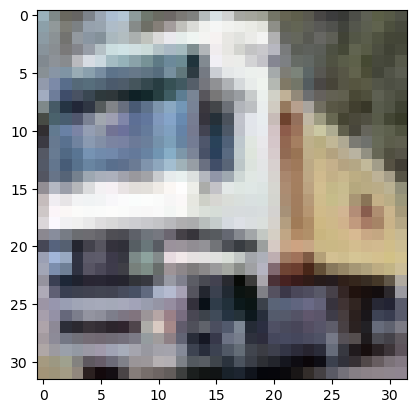

In [3]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import numpy as np

dataset = CIFAR10(root='CIFAR10', download=True,transform=transforms.Compose([transforms.ToTensor()]))

import matplotlib.pyplot as plt

plt.imshow(dataset[1][0].permute([1, 2, 0]))

batch_size = 64
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
class ForwardDiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, x_0_tensor, t_batch_tensor, suff_stats_tensor):
        super().__init__()
        self.x_0_tensor = x_0_tensor
        self.t_batch_tensor = t_batch_tensor
        self.suff_stats_tensor = suff_stats_tensor

    def __len__(self):
        return self.x_0_tensor.shape[0]
        
    def __getitem__(self, idx):
        return self.x_0_tensor[idx], self.t_batch_tensor[idx], self.suff_stats_tensor[idx]
    
def load_generated_dataset():
    x_0_tensor, t_batch_tensor, suff_stats_tensor = torch.load('x_0_dataset_cifar.pth'), torch.load('t_batch_dataset_cifar.pth'), torch.load('suff_stats_dataset_cifar.pth')
    return ForwardDiffusionDataset(x_0_tensor, t_batch_tensor, suff_stats_tensor)

forward_diffusion_dataset = load_generated_dataset()


forward_diffusion_dataloader = torch.utils.data.DataLoader(forward_diffusion_dataset, batch_size=batch_size, shuffle=True)

In [5]:
import torch.nn.functional as F
from models import UNet
device = 'cuda'

class BetaUnetCifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = UNet(3, 32, (1, 2, 4, 8), time_emb_dim=16)

    def forward(self, suff_stats, t):
        return F.sigmoid(self.model(suff_stats, t))


In [6]:

# model = BetaUnetCifar()
model = model.to(device)
# model.load_state_dict(torch.load('beta_ddpm_cifar.pth'))

# opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:

train_generated_dataset(model, opt, forward_diffusion_dataloader, max_iter=40000)


Iter 10228 Loss: 0.0202:  26%|███████████▊                                  | 10228/40000 [19:08<57:13,  8.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iter 19259 Loss: 0.0223:  48%|██████████████████████▏                       | 19259/40000 [35:43<38:53,  8.89it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iter 24911 Loss: 0.0118:  62%|████████████████████████████▋                 | 24912/40000 [46:04<27:38,  9.10it/s]IOPub me

KeyboardInterrupt: 

In [8]:
torch.save(model.state_dict(), 'beta_ddpm_cifar.pth')

100%|███████████████████████████████████████████████████████████████████████████| 999/999 [00:21<00:00, 46.42it/s]


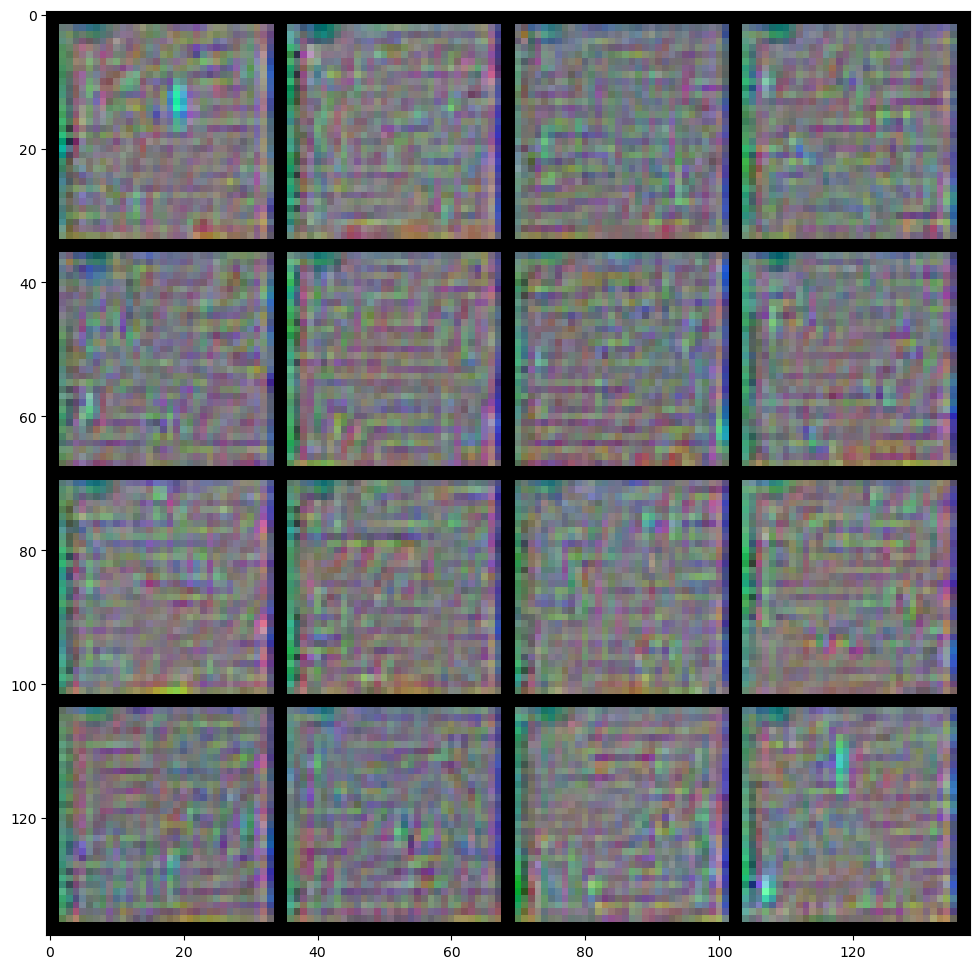

In [9]:
samples, samples_history, x_0_samples_history = generate_alpha_normed(model)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

plt.figure(figsize = (12,12))

img = np.asarray(Image.open('beta_ssddpm_samples_cifar.png'))
imgplot = plt.imshow(img)

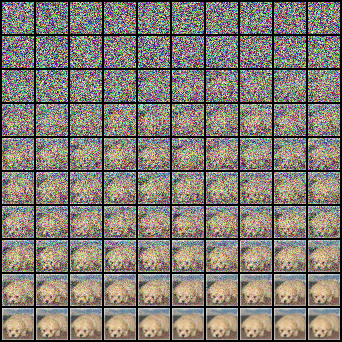

In [14]:

t_batch = torch.tensor([0], device=device).repeat(batch_size)

x_0 = next(iter(dataloader))[0].to(device)
samples, suff_stats_normed = sample_chain_suff_stats_norm_alpha(t_batch, x_0)

img_grid = torchvision.utils.make_grid(torch.cat([item[0].unsqueeze(0) for item in samples[::10]], dim=0) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)

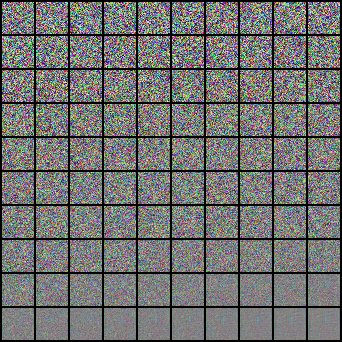

In [12]:
# samples_history[0].shape

img_grid = torchvision.utils.make_grid(torch.cat([item[0].unsqueeze(0) for item in samples_history[::10]], dim=0) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)

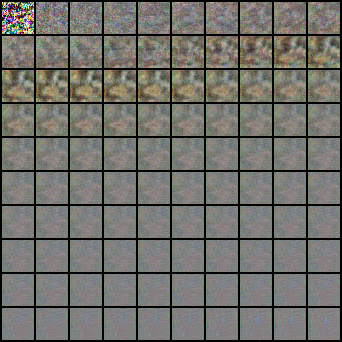

In [13]:
# samples_history[0].shape

img_grid = torchvision.utils.make_grid(torch.cat([item[0].unsqueeze(0) for item in x_0_samples_history[::10]], dim=0) ,nrow=10,normalize=True)
torchvision.transforms.ToPILImage()(img_grid)

In [20]:
torch.cat([item[0].unsqueeze(0) for item in samples[::10]], dim=0).shape

torch.Size([100, 3, 32, 32])

In [14]:
samples[0].shape

torch.Size([64, 3, 32, 32])

###  Generate dataset

In [ ]:
batch_size = 512

def generate_dataset(pic_dataloader, n_samples, batch_size=1024, save_path='generated_dataset.pth'):
    n_iters = n_samples // batch_size
    
    x_0_storage = []
    t_batch_storage = []
    suff_stats_storage = []
    
    for i in tqdm(range(n_iters)):
        x_0 = next(iter(pic_dataloader))[0].to(device)
        t_batch = sample_t_batch(batch_size)
        samples, suff_stats = sample_chain_suff_stats_norm_alpha(t_batch, x_0)
        
        del samples
        x_0_storage.append(x_0.cpu())
        t_batch_storage.append(t_batch.cpu())
        suff_stats_storage.append(suff_stats.cpu())
        
    x_0_tensor = torch.cat(x_0_storage, dim=0)
    t_batch_tensor = torch.cat(t_batch_storage, dim=0)
    suff_stats_tensor = torch.cat(suff_stats_storage, dim=0)
    return x_0_tensor, t_batch_tensor, suff_stats_tensor


dataset = CIFAR10(root='CIFAR10', download=True,transform=transforms.Compose([transforms.ToTensor()]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
n_samples = 500000
x_0_tensor, t_batch_tensor, suff_stats_tensor = generate_dataset(dataloader, n_samples, batch_size=batch_size)

torch.save(x_0_tensor, 'x_0_dataset_cifar.pth')
torch.save(t_batch_tensor, 't_batch_dataset_cifar.pth')
torch.save(suff_stats_tensor, 'suff_stats_dataset_cifar.pth')


Files already downloaded and verified


  0%|▏                                                                          | 3/976 [00:30<2:42:38, 10.03s/it]